# Using Legendre polynomials as features

I was running the [example from scikit-learn site](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), that demonstrated the underfitting and overfitting. Below is a modified version of this code.

Degree:  1  Coefficients:  [-1.60931179]
Degree:  4  Coefficients:  [  0.46754142 -17.78954475  23.5926603   -7.26289872]
Degree:  15  Coefficients:  [-2.98294669e+03  1.03899932e+05 -1.87417069e+06  2.03717225e+07
 -1.44873987e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08]


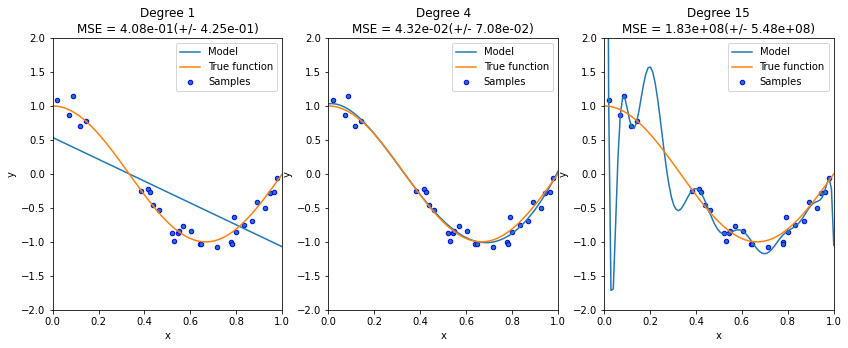

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print("Degree: ", degrees[i], " Coefficients: ", pipeline.steps[1][1].coef_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

However, when we try to use a gradient descent-based algorithm, we do not see overfitting on the degree 15 polynomial:

Precision:  0.001  Coefficients:  [-1.45638921 -5.39845503 -0.08210397  3.16955786  3.69426481  2.62457999
  0.99244665 -0.54715913 -1.65294244 -2.18860607 -2.13602685 -1.53800473
 -0.46402348  1.00881274  2.80563863]
Iterations:  [5]
Precision:  1e-05  Coefficients:  [-1.83594339 -3.88578813 -1.43719913  2.21796145  3.89415266  3.4600935
  1.86509454 -0.01004114 -1.60622115 -2.62231404 -2.90991867 -2.40047854
 -1.0668092   1.09404043  4.06769693]
Iterations:  [8]
Precision:  1e-07  Coefficients:  [    3.04887327   -78.33941923   430.76216498 -1060.3274159
   822.91790905   615.99693557  -513.83963655  -800.57227194
  -159.35863125   584.59205784   730.50334497   169.697291
  -618.56499873  -782.99169153   655.34069177]
Iterations:  [20]
Precision:  1e-11  Coefficients:  [-4.52556083e+01  1.03969260e+03 -1.07617651e+04  5.62591183e+04
 -1.58409742e+05  2.26596329e+05 -9.38648238e+04 -1.32499506e+05
  1.00952317e+05  1.05480059e+05 -7.81991863e+04 -8.51330656e+04
  7.58005123e+04  4.011

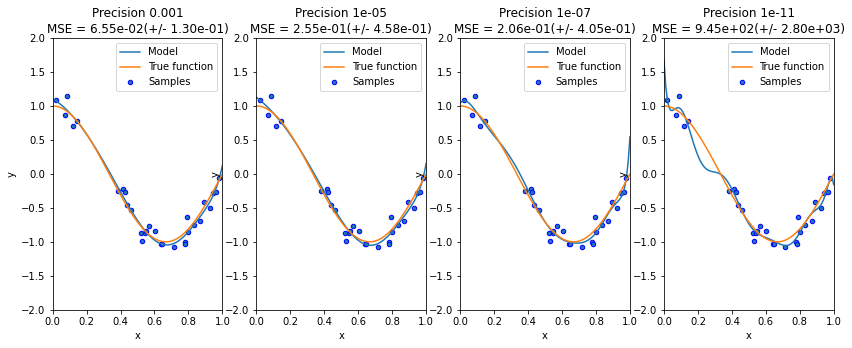

In [13]:
np.random.seed(0)

n_samples = 30
degree = 15
precisions = [1E-3, 1E-5, 1E-7, 1E-11]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i, precision in enumerate(precisions):
    ax = plt.subplot(1, len(precisions), i + 1)

    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    scaler = MinMaxScaler()
    linear_regression = Ridge(alpha=0, solver='lsqr', tol=precision, max_iter=10000)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("scaler", scaler),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print("Precision: ", precision, " Coefficients: ", pipeline.steps[-1][1].coef_)
    print('Iterations: ', pipeline.steps[-1][1].n_iter_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Precision {}\nMSE = {:.2e}(+/- {:.2e})".format(
        precision, -scores.mean(), scores.std()))
plt.show()

Indeed, the predicted function is close to the true function, even though the data are quite noisy. This led some to believe that the gradient descent-based optimization procedure has a regularizing effect. However, the reason may be in the data. Indeed, let us consider the correlation between features:

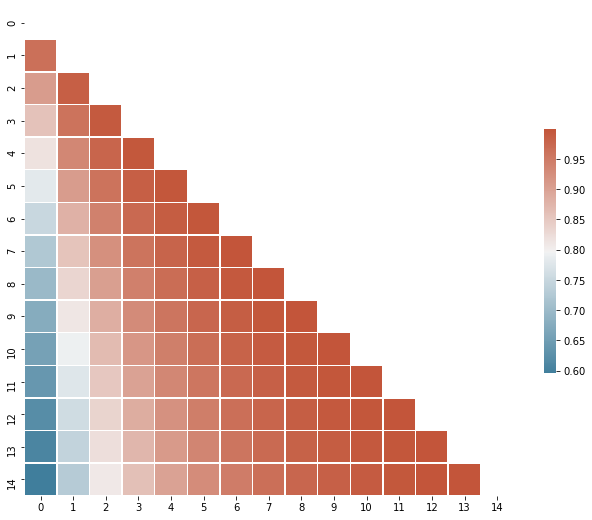

In [10]:
import pandas as pd
import seaborn as sns
corr = pd.DataFrame(polynomial_features.transform(X.reshape(-1, 1))).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

We see that the generated features are highly correlated. To decorrelate the features many people use methods like PCA. However we will use Legendre polynomials which are uncorrelated *a priori*.

In [28]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.special import legendre
class UnivariateLegendreFeatures(TransformerMixin, BaseEstimator):
    """
    Generates new features using Legendre polynomials on the input features.
    
    This implementation does NOT use feature interaction
    """
    
    def __init__(self, degree):
        self.degree = degree

    def fit(self, X, y=None):
        """
        We need to bring the input data to the interval [-1, 1]
        """
        X0 = X.min(axis=0, keepdims=True)
        X1 = X.max(axis=0, keepdims=True)
        self.a = - (X1+X0)/(X1-X0)
        self.b = 2/(X1-X0)
        return self

    def transform(self, X):
        X = self.a + self.b * X
        return np.hstack([legendre(deg)(X) for deg in range(self.degree+1)])


Precision:  0.1  Coefficients:  [ 0.         -0.78602307  0.7453521   0.22365896  0.0665091   0.10440632
 -0.12313952  0.22757163 -0.06491127 -0.08214078  0.19288558  0.00278865
  0.13578941 -0.11294585  0.10055211  0.00117265]
Iterations:  [2]
Precision:  0.01  Coefficients:  [ 0.         -0.66395983  0.61363038  0.58726948 -0.51300479  0.70501896
 -0.73529786  0.15586926  0.40791402 -0.37322967  0.13421736  0.21080997
 -0.0680323  -0.58685704  1.08638707 -0.61209186]
Iterations:  [13]
Precision:  0.001  Coefficients:  [ 0.         -0.80081152  0.52247933  0.92853165 -0.82576247  0.70370429
 -0.45584405 -0.09634313  0.380725   -0.12265576 -0.07302771  0.1791428
  0.14139362 -0.78715172  1.13894609 -0.58071385]
Iterations:  [17]
Precision:  0.0001  Coefficients:  [ 0.         -0.80081152  0.52247933  0.92853165 -0.82576247  0.70370429
 -0.45584405 -0.09634313  0.380725   -0.12265576 -0.07302771  0.1791428
  0.14139362 -0.78715172  1.13894609 -0.58071385]
Iterations:  [17]


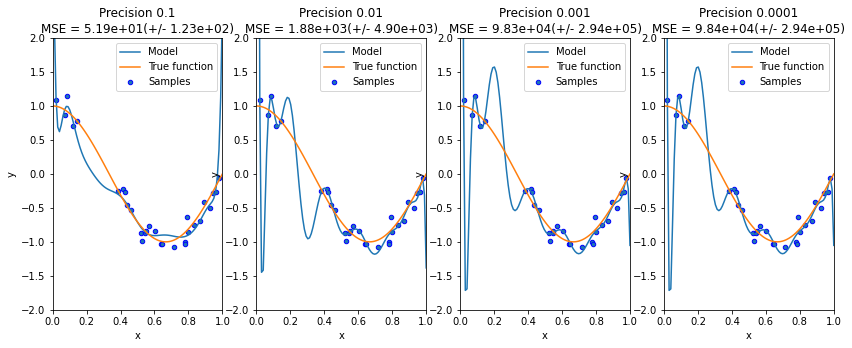

In [29]:
np.random.seed(0)

n_samples = 30
degree = 15
precisions = [1E-1, 1E-2, 1E-3, 1E-4]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i, precision in enumerate(precisions):
    ax = plt.subplot(1, len(precisions), i + 1)

    polynomial_features = UnivariateLegendreFeatures(degree=degree)
    scaler = MinMaxScaler()
    linear_regression = Ridge(alpha=0, solver='lsqr', tol=precision, max_iter=10000)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print("Precision: ", precision, " Coefficients: ", pipeline.steps[-1][1].coef_)
    print('Iterations: ', pipeline.steps[-1][1].n_iter_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Precision {}\nMSE = {:.2e}(+/- {:.2e})".format(
        precision, -scores.mean(), scores.std()))
plt.show()

We see that the algorithm converges much faster to the closed-form solution due to the fact that the features are uncorrelated